<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%206/Assignment%20S6%20-%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
os.listdir()

['.config', 'asgnmnt6-0.0.32-py3-none-any.whl', 'sample_data']

In [4]:
pip install asgnmnt6-0.0.32-py3-none-any.whl

Processing ./asgnmnt6-0.0.32-py3-none-any.whl


## Loading Packages

In [0]:
from __future__ import print_function
import torch
import torch.optim as optim


import os

from asgnmnt6.GBNModel import GBNNet
from asgnmnt6.Model import Net
from asgnmnt6.DataTransformation import DataTransformation
from asgnmnt6.TrainTest import TrainTest

## Loading Train and Test Data

In [6]:
cuda = torch.cuda.is_available()
print("CUDA Available?", torch.cuda.is_available())

dt = DataTransformation()
# train dataloader
train_loader = dt.TrainPrep()
# test dataloader
test_loader = dt.TrainPrep()

CUDA Available? True


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Model Sumary

In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print("####### with Ghost Batch Normalization######")
model = GBNNet().to(device)
summary(model, input_size=(1, 28, 28))


cuda
####### with Ghost Batch Normalization######


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
    GhostBatchNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
    GhostBatchNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
   GhostBatchNorm-13           [-1, 16, 10, 10]    

In [8]:
torch.cuda.is_available()

True

In [9]:
print("####### with Batch Normalization######")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

####### with Batch Normalization######
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32


## Training Model

In [10]:
from torch.optim.lr_scheduler import StepLR

models_ = {
            1:{'L1' : False,'L2' : False,'GBN':False},
            2:{'L1' : False,'L2' : False,'GBN':True},
            3:{'L1' : True,'L2' : False,'GBN':False},
            4:{'L1' : True,'L2': False,'GBN':True},
            5:{'L1' : False,'L2' : True,'GBN':False},
            6:{'L1' : False,'L2' : True,'GBN':True},
            7:{'L1' : True,'L2' : True,'GBN':False},
            8:{'L1' : True,'L2': False,'GBN':True}
            }

for i in list(range(1,9)):
    print('##############################################################')
    print('L1:{},L2:{},GBN:{}'.format(models_[i]['L1'],models_[i]['L2'],models_[i]['GBN']))
    if (models_[i]['GBN']==False):
        model =  Net().to(device)
    else:
        model =  GBNNet().to(device)
    
    def Optimizer_(L2 = models_[i]['L2']):
        if (L2 == False):
            optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
        else:
            optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9,weight_decay = 0.00005)
        return optimizer
    optimizer = Optimizer_(L2 = True)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    tt = TrainTest()
    EPOCHS = 25
    test_acc = 0
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        tt.train_(model, device, train_loader, optimizer, epoch,L1 = models_[i]['L1'])
        scheduler.step()
        acc = tt.test_(model, device, test_loader)
        if acc>=test_acc:
            models_[i]['Saved Model'] = model.state_dict()
                
    models_[i]['Training Loss'] = tt.train_losses
    models_[i]["Training Accuracy"] = tt.train_acc[4000:]
    models_[i]['Test Loss'] = tt.test_losses
    models_[i]["Test Accuracy"] = tt.test_acc

  0%|          | 0/469 [00:00<?, ?it/s]

##############################################################
L1:False,L2:False,GBN:False
EPOCH: 0


Loss=0.14055269956588745 Batch_id=468 Accuracy=92.19: 100%|██████████| 469/469 [00:12<00:00, 38.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 58393/60000 (97.32%)

EPOCH: 1


Loss=0.04819394275546074 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 59000/60000 (98.33%)

EPOCH: 2


Loss=0.024678392335772514 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:12<00:00, 38.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 59340/60000 (98.90%)

EPOCH: 3


Loss=0.03685256093740463 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 59158/60000 (98.60%)

EPOCH: 4


Loss=0.15705512464046478 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 59371/60000 (98.95%)

EPOCH: 5


Loss=0.07022038847208023 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 59497/60000 (99.16%)

EPOCH: 6


Loss=0.02523750066757202 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 59597/60000 (99.33%)

EPOCH: 7


Loss=0.06131305918097496 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 59619/60000 (99.36%)

EPOCH: 8


Loss=0.06972768902778625 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 38.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 59593/60000 (99.32%)

EPOCH: 9


Loss=0.006758218165487051 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 59620/60000 (99.37%)

EPOCH: 10


Loss=0.08852192014455795 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:12<00:00, 38.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 59637/60000 (99.39%)

EPOCH: 11


Loss=0.044369325041770935 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 59634/60000 (99.39%)

EPOCH: 12


Loss=0.01169647742062807 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 37.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 59614/60000 (99.36%)

EPOCH: 13


Loss=0.013981178402900696 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 59639/60000 (99.40%)

EPOCH: 14


Loss=0.08706953376531601 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59635/60000 (99.39%)

EPOCH: 15


Loss=0.0456235446035862 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59651/60000 (99.42%)

EPOCH: 16


Loss=0.05601775273680687 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 37.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 59657/60000 (99.43%)

EPOCH: 17


Loss=0.01139764953404665 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 59637/60000 (99.39%)

EPOCH: 18


Loss=0.052403464913368225 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 59667/60000 (99.44%)

EPOCH: 19


Loss=0.029757022857666016 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 37.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59647/60000 (99.41%)

EPOCH: 20


Loss=0.08215590566396713 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59669/60000 (99.45%)

EPOCH: 21


Loss=0.02268245816230774 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59650/60000 (99.42%)

EPOCH: 22


Loss=0.010340397246181965 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 37.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 59641/60000 (99.40%)

EPOCH: 23


Loss=0.021383345127105713 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 59631/60000 (99.39%)

EPOCH: 24


Loss=0.08313380926847458 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 37.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 59620/60000 (99.37%)

##############################################################
L1:False,L2:False,GBN:True
EPOCH: 0


Loss=0.1215072050690651 Batch_id=468 Accuracy=92.58: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 58647/60000 (97.75%)

EPOCH: 1


Loss=0.05740365386009216 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 58895/60000 (98.16%)

EPOCH: 2


Loss=0.038276515901088715 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:12<00:00, 37.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 59236/60000 (98.73%)

EPOCH: 3


Loss=0.06317605078220367 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 37.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 59300/60000 (98.83%)

EPOCH: 4


Loss=0.038796499371528625 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:12<00:00, 37.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 59466/60000 (99.11%)

EPOCH: 5


Loss=0.014293685555458069 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 59402/60000 (99.00%)

EPOCH: 6


Loss=0.11371704190969467 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 59614/60000 (99.36%)

EPOCH: 7


Loss=0.03212539479136467 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 59627/60000 (99.38%)

EPOCH: 8


Loss=0.06763723492622375 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 59603/60000 (99.34%)

EPOCH: 9


Loss=0.022807857021689415 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 59636/60000 (99.39%)

EPOCH: 10


Loss=0.036847203969955444 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 36.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 59641/60000 (99.40%)

EPOCH: 11


Loss=0.007460226770490408 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59637/60000 (99.39%)

EPOCH: 12


Loss=0.04087323695421219 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 59653/60000 (99.42%)

EPOCH: 13


Loss=0.03807501494884491 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 59640/60000 (99.40%)

EPOCH: 14


Loss=0.005060955882072449 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 59656/60000 (99.43%)

EPOCH: 15


Loss=0.051559481769800186 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 59666/60000 (99.44%)

EPOCH: 16


Loss=0.02407093346118927 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 59650/60000 (99.42%)

EPOCH: 17


Loss=0.0059373280964791775 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 59656/60000 (99.43%)

EPOCH: 18


Loss=0.005321567412465811 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 59659/60000 (99.43%)

EPOCH: 19


Loss=0.02490849792957306 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 59636/60000 (99.39%)

EPOCH: 20


Loss=0.004524449352174997 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 59649/60000 (99.42%)

EPOCH: 21


Loss=0.015148465521633625 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 59636/60000 (99.39%)

EPOCH: 22


Loss=0.008614063262939453 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 59665/60000 (99.44%)

EPOCH: 23


Loss=0.07951688021421432 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 59665/60000 (99.44%)

EPOCH: 24


Loss=0.006332611199468374 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 59665/60000 (99.44%)

##############################################################
L1:True,L2:False,GBN:False
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.37440234422683716 Batch_id=468 Accuracy=92.08: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Accuracy: 58241/60000 (97.07%)

EPOCH: 1


Loss=0.33920368552207947 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:14<00:00, 32.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0974, Accuracy: 58273/60000 (97.12%)

EPOCH: 2


Loss=0.47626596689224243 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1110, Accuracy: 57920/60000 (96.53%)

EPOCH: 3


Loss=0.3224242031574249 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0752, Accuracy: 58613/60000 (97.69%)

EPOCH: 4


Loss=0.29296544194221497 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 58966/60000 (98.28%)

EPOCH: 5


Loss=0.34894391894340515 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 58508/60000 (97.51%)

EPOCH: 6


Loss=0.24481424689292908 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 59400/60000 (99.00%)

EPOCH: 7


Loss=0.18320469558238983 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 59347/60000 (98.91%)

EPOCH: 8


Loss=0.15703517198562622 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 59358/60000 (98.93%)

EPOCH: 9


Loss=0.20016613602638245 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 59380/60000 (98.97%)

EPOCH: 10


Loss=0.17046383023262024 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 59252/60000 (98.75%)

EPOCH: 11


Loss=0.1585105061531067 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 59081/60000 (98.47%)

EPOCH: 12


Loss=0.1308276355266571 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 59407/60000 (99.01%)

EPOCH: 13


Loss=0.24105727672576904 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 32.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 59464/60000 (99.11%)

EPOCH: 14


Loss=0.14160481095314026 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 59461/60000 (99.10%)

EPOCH: 15


Loss=0.24777373671531677 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 59442/60000 (99.07%)

EPOCH: 16


Loss=0.12311388552188873 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 59495/60000 (99.16%)

EPOCH: 17


Loss=0.17733460664749146 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 59459/60000 (99.10%)

EPOCH: 18


Loss=0.12391401082277298 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 59496/60000 (99.16%)

EPOCH: 19


Loss=0.19893312454223633 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 59479/60000 (99.13%)

EPOCH: 20


Loss=0.1451111137866974 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 59448/60000 (99.08%)

EPOCH: 21


Loss=0.12382547557353973 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 59489/60000 (99.15%)

EPOCH: 22


Loss=0.15653036534786224 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 59438/60000 (99.06%)

EPOCH: 23


Loss=0.14793066680431366 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 59456/60000 (99.09%)

EPOCH: 24


Loss=0.18098214268684387 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 59445/60000 (99.08%)

##############################################################
L1:True,L2:False,GBN:True
EPOCH: 0


Loss=0.36473968625068665 Batch_id=468 Accuracy=91.27: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1383, Accuracy: 57513/60000 (95.86%)

EPOCH: 1


Loss=0.42227596044540405 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1322, Accuracy: 57454/60000 (95.76%)

EPOCH: 2


Loss=0.3158800005912781 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1004, Accuracy: 58101/60000 (96.83%)

EPOCH: 3


Loss=0.29219362139701843 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0719, Accuracy: 58674/60000 (97.79%)

EPOCH: 4


Loss=0.2607964873313904 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 58213/60000 (97.02%)

EPOCH: 5


Loss=0.254911333322525 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0735, Accuracy: 58637/60000 (97.73%)

EPOCH: 6


Loss=0.22072969377040863 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 59415/60000 (99.03%)

EPOCH: 7


Loss=0.20332905650138855 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 59426/60000 (99.04%)

EPOCH: 8


Loss=0.15673722326755524 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 59408/60000 (99.01%)

EPOCH: 9


Loss=0.20233960449695587 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 59434/60000 (99.06%)

EPOCH: 10


Loss=0.21809017658233643 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0329, Accuracy: 59392/60000 (98.99%)

EPOCH: 11


Loss=0.16973602771759033 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 59428/60000 (99.05%)

EPOCH: 12


Loss=0.14817313849925995 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 30.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 59520/60000 (99.20%)

EPOCH: 13


Loss=0.13982626795768738 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:15<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 59520/60000 (99.20%)

EPOCH: 14


Loss=0.15137720108032227 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 59505/60000 (99.17%)

EPOCH: 15


Loss=0.14449353516101837 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 59532/60000 (99.22%)

EPOCH: 16


Loss=0.13571716845035553 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:15<00:00, 31.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 59529/60000 (99.22%)

EPOCH: 17


Loss=0.169060617685318 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 59504/60000 (99.17%)

EPOCH: 18


Loss=0.1446983516216278 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 59530/60000 (99.22%)

EPOCH: 19


Loss=0.15302978456020355 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 59551/60000 (99.25%)

EPOCH: 20


Loss=0.15113480389118195 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 59523/60000 (99.20%)

EPOCH: 21


Loss=0.1549338698387146 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 59540/60000 (99.23%)

EPOCH: 22


Loss=0.16880068182945251 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 59555/60000 (99.26%)

EPOCH: 23


Loss=0.13512860238552094 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 59573/60000 (99.29%)

EPOCH: 24


Loss=0.1501988172531128 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 59536/60000 (99.23%)

##############################################################
L1:False,L2:True,GBN:False
EPOCH: 0


Loss=0.046395864337682724 Batch_id=468 Accuracy=92.28: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0762, Accuracy: 58559/60000 (97.60%)

EPOCH: 1


Loss=0.05483522638678551 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 58691/60000 (97.82%)

EPOCH: 2


Loss=0.05555186793208122 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 59056/60000 (98.43%)

EPOCH: 3


Loss=0.0739184319972992 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 59107/60000 (98.51%)

EPOCH: 4


Loss=0.02432972751557827 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:13<00:00, 34.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 59138/60000 (98.56%)

EPOCH: 5


Loss=0.08759959787130356 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 59386/60000 (98.98%)

EPOCH: 6


Loss=0.17176006734371185 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 59503/60000 (99.17%)

EPOCH: 7


Loss=0.03692961856722832 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 59526/60000 (99.21%)

EPOCH: 8


Loss=0.006929566618055105 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 59527/60000 (99.21%)

EPOCH: 9


Loss=0.02373684011399746 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 59569/60000 (99.28%)

EPOCH: 10


Loss=0.08431772142648697 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 59587/60000 (99.31%)

EPOCH: 11


Loss=0.018653949722647667 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 59608/60000 (99.35%)

EPOCH: 12


Loss=0.01088598370552063 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 59572/60000 (99.29%)

EPOCH: 13


Loss=0.01497166883200407 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 59602/60000 (99.34%)

EPOCH: 14


Loss=0.01938212849199772 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 59602/60000 (99.34%)

EPOCH: 15


Loss=0.030344611033797264 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 59611/60000 (99.35%)

EPOCH: 16


Loss=0.02813405729830265 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 59585/60000 (99.31%)

EPOCH: 17


Loss=0.0007751186494715512 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 59574/60000 (99.29%)

EPOCH: 18


Loss=0.014110307209193707 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 59614/60000 (99.36%)

EPOCH: 19


Loss=0.03915136680006981 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 59598/60000 (99.33%)

EPOCH: 20


Loss=0.008493468165397644 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 59587/60000 (99.31%)

EPOCH: 21


Loss=0.030037233605980873 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 59604/60000 (99.34%)

EPOCH: 22


Loss=0.028916195034980774 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 59581/60000 (99.30%)

EPOCH: 23


Loss=0.017145926132798195 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 59618/60000 (99.36%)

EPOCH: 24


Loss=0.025102093815803528 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 34.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 59601/60000 (99.33%)

##############################################################
L1:False,L2:True,GBN:True
EPOCH: 0


Loss=0.1276634931564331 Batch_id=468 Accuracy=91.94: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 58577/60000 (97.63%)

EPOCH: 1


Loss=0.06707867234945297 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:13<00:00, 34.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 59104/60000 (98.51%)

EPOCH: 2


Loss=0.15944521129131317 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 59085/60000 (98.47%)

EPOCH: 3


Loss=0.03906019777059555 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 59408/60000 (99.01%)

EPOCH: 4


Loss=0.10689430683851242 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 59407/60000 (99.01%)

EPOCH: 5


Loss=0.14432479441165924 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 59351/60000 (98.92%)

EPOCH: 6


Loss=0.03539104759693146 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 59577/60000 (99.30%)

EPOCH: 7


Loss=0.04708225652575493 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 59594/60000 (99.32%)

EPOCH: 8


Loss=0.013604109175503254 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 59599/60000 (99.33%)

EPOCH: 9


Loss=0.033500608056783676 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 59603/60000 (99.34%)

EPOCH: 10


Loss=0.019573157653212547 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 59615/60000 (99.36%)

EPOCH: 11


Loss=0.0028697948437184095 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 59619/60000 (99.36%)

EPOCH: 12


Loss=0.035921361297369 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 33.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 59620/60000 (99.37%)

EPOCH: 13


Loss=0.004392122384160757 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 59636/60000 (99.39%)

EPOCH: 14


Loss=0.00618569552898407 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59637/60000 (99.39%)

EPOCH: 15


Loss=0.016431786119937897 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 59623/60000 (99.37%)

EPOCH: 16


Loss=0.024364516139030457 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 59629/60000 (99.38%)

EPOCH: 17


Loss=0.022586500272154808 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 59610/60000 (99.35%)

EPOCH: 18


Loss=0.021918991580605507 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 59628/60000 (99.38%)

EPOCH: 19


Loss=0.03230350837111473 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 34.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 59611/60000 (99.35%)

EPOCH: 20


Loss=0.004271666053682566 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 59619/60000 (99.36%)

EPOCH: 21


Loss=0.026811018586158752 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 59643/60000 (99.41%)

EPOCH: 22


Loss=0.004875550512224436 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59627/60000 (99.38%)

EPOCH: 23


Loss=0.014086375944316387 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59639/60000 (99.40%)

EPOCH: 24


Loss=0.021321872249245644 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 59626/60000 (99.38%)

##############################################################
L1:True,L2:True,GBN:False
EPOCH: 0


Loss=0.38527292013168335 Batch_id=468 Accuracy=92.02: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0962, Accuracy: 58230/60000 (97.05%)

EPOCH: 1


Loss=0.4022873342037201 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1321, Accuracy: 57568/60000 (95.95%)

EPOCH: 2


Loss=0.2827116549015045 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0778, Accuracy: 58557/60000 (97.59%)

EPOCH: 3


Loss=0.26187247037887573 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0758, Accuracy: 58683/60000 (97.81%)

EPOCH: 4


Loss=0.2900279760360718 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0884, Accuracy: 58334/60000 (97.22%)

EPOCH: 5


Loss=0.3497875928878784 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 58582/60000 (97.64%)

EPOCH: 6


Loss=0.28438666462898254 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 59401/60000 (99.00%)

EPOCH: 7


Loss=0.27641335129737854 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 59392/60000 (98.99%)

EPOCH: 8


Loss=0.19931383430957794 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 59415/60000 (99.03%)

EPOCH: 9


Loss=0.17651093006134033 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 59342/60000 (98.90%)

EPOCH: 10


Loss=0.15852536261081696 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 59353/60000 (98.92%)

EPOCH: 11


Loss=0.16171960532665253 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 59306/60000 (98.84%)

EPOCH: 12


Loss=0.19761928915977478 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 59494/60000 (99.16%)

EPOCH: 13


Loss=0.13777993619441986 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 59491/60000 (99.15%)

EPOCH: 14


Loss=0.1676836907863617 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 59498/60000 (99.16%)

EPOCH: 15


Loss=0.14315660297870636 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 59482/60000 (99.14%)

EPOCH: 16


Loss=0.15365277230739594 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 59495/60000 (99.16%)

EPOCH: 17


Loss=0.13253670930862427 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 59480/60000 (99.13%)

EPOCH: 18


Loss=0.14985662698745728 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 59508/60000 (99.18%)

EPOCH: 19


Loss=0.1334485411643982 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 59495/60000 (99.16%)

EPOCH: 20


Loss=0.1325007975101471 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 59497/60000 (99.16%)

EPOCH: 21


Loss=0.1342747062444687 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 59508/60000 (99.18%)

EPOCH: 22


Loss=0.16326148808002472 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 59497/60000 (99.16%)

EPOCH: 23


Loss=0.1226189061999321 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 59489/60000 (99.15%)

EPOCH: 24


Loss=0.1314854770898819 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 59510/60000 (99.18%)

##############################################################
L1:True,L2:False,GBN:True
EPOCH: 0


Loss=0.3629940152168274 Batch_id=468 Accuracy=91.92: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1074, Accuracy: 58114/60000 (96.86%)

EPOCH: 1


Loss=0.32518985867500305 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0778, Accuracy: 58640/60000 (97.73%)

EPOCH: 2


Loss=0.27880027890205383 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0820, Accuracy: 58552/60000 (97.59%)

EPOCH: 3


Loss=0.2530321180820465 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:15<00:00, 29.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0682, Accuracy: 58814/60000 (98.02%)

EPOCH: 4


Loss=0.35580962896347046 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0858, Accuracy: 58475/60000 (97.46%)

EPOCH: 5


Loss=0.2845724821090698 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 58488/60000 (97.48%)

EPOCH: 6


Loss=0.2046465128660202 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 59412/60000 (99.02%)

EPOCH: 7


Loss=0.19247101247310638 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 59349/60000 (98.92%)

EPOCH: 8


Loss=0.19250820577144623 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 59339/60000 (98.90%)

EPOCH: 9


Loss=0.1723674088716507 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 59410/60000 (99.02%)

EPOCH: 10


Loss=0.14076350629329681 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 59199/60000 (98.67%)

EPOCH: 11


Loss=0.20053231716156006 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 27.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 59134/60000 (98.56%)

EPOCH: 12


Loss=0.15975533425807953 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 59504/60000 (99.17%)

EPOCH: 13


Loss=0.16526983678340912 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 59472/60000 (99.12%)

EPOCH: 14


Loss=0.1414341926574707 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 59529/60000 (99.22%)

EPOCH: 15


Loss=0.1416957676410675 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 59492/60000 (99.15%)

EPOCH: 16


Loss=0.1402842402458191 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 27.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 59520/60000 (99.20%)

EPOCH: 17


Loss=0.15213319659233093 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 59498/60000 (99.16%)

EPOCH: 18


Loss=0.17429858446121216 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 59527/60000 (99.21%)

EPOCH: 19


Loss=0.14379757642745972 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 59505/60000 (99.17%)

EPOCH: 20


Loss=0.14839684963226318 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 59536/60000 (99.23%)

EPOCH: 21


Loss=0.16027028858661652 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 59549/60000 (99.25%)

EPOCH: 22


Loss=0.20700231194496155 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 59528/60000 (99.21%)

EPOCH: 23


Loss=0.14917150139808655 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 59516/60000 (99.19%)

EPOCH: 24


Loss=0.20284894108772278 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]



Test set: Average loss: 0.0259, Accuracy: 59526/60000 (99.21%)



## Test Accuracy Plot

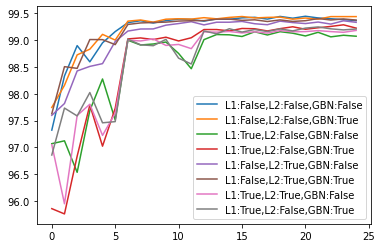

In [11]:
import matplotlib.pyplot as plt
for i in list(range(1,9)):
    plt.plot(models_[i]['Test Accuracy'],label='L1:{},L2:{},GBN:{}'.format(models_[i]['L1'],models_[i]['L2'],models_[i]['GBN']))
    plt.legend()

## Test Loss Plot

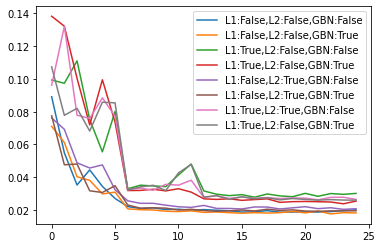

In [12]:
for i in list(range(1,9)):
    plt.plot(models_[i]['Test Loss'],label='L1:{},L2:{},GBN:{}'.format(models_[i]['L1'],models_[i]['L2'],models_[i]['GBN']))
    plt.legend()


## Misclassified Images in "without L1/L2 with BN" AND "without L1/L2 with GBN"

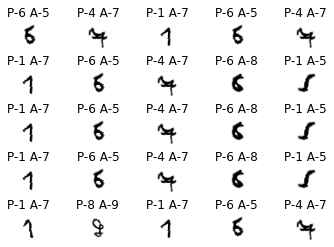

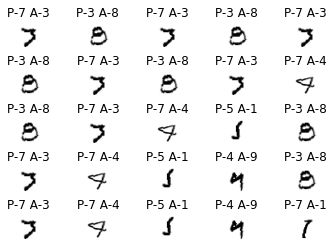

In [13]:
import numpy as np
from google.colab import files

for m_id in [1,2]:
    model = GBNNet().to(device)
    model.load_state_dict(models_[m_id]['Saved Model'])
    model.eval()
    
    correct = 0
    pred_wrong = []
    true_wrong = []
    image = []
    pred_wrong_t=[]
    true_wrong_t=[]
    image_t=[]
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds = (pred.cuda()).cpu().numpy()
        target = (target.cuda()).cpu().numpy()
    
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = (data.cuda()).cpu().numpy()
        
        for i in range(len(preds)):
    
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
                
        pred_wrong_t.extend(pred_wrong)
        true_wrong_t.extend(true_wrong)
        image_t.extend(image)
    
    
    
    figure = plt.figure()
    num_of_images = 25
    for index in range(1, num_of_images + 1):
        plt.subplot(5,5, index)
        plt.subplots_adjust(hspace=.9)
        plt.axis('off')
        plt.imshow(image_t[index].squeeze(), cmap='gray_r')
        a='P-'+str(int(pred_wrong_t[index]))+' A-'+str(int(true_wrong_t[index]))
        plt.title(a)
    
    label='L1-{},L2-{},GBN-{}'.format(models_[m_id]['L1'],models_[m_id]['L2'],models_[m_id]['GBN'])
    figure.savefig(label+'.png')
    files.download(label+'.png')
